✅ Total images found: 3264
🧾 Class distribution:
 class
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
                                               filename            class
443   /kaggle/input/sartaj-dataset/Training/pituitar...  pituitary_tumor
370   /kaggle/input/sartaj-dataset/Training/no_tumor...         no_tumor
2846  /kaggle/input/sartaj-dataset/Training/glioma_t...     glioma_tumor
42    /kaggle/input/sartaj-dataset/Training/no_tumor...         no_tumor
776   /kaggle/input/sartaj-dataset/Training/pituitar...  pituitary_tumor
Found 2219 validated image filenames belonging to 4 classes.
Found 392 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 127s 798ms/step - accuracy: 0.6261 - loss: 0.9758 - val_accuracy: 0.6097 - val_loss: 1.1343
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 400ms/step - accuracy: 0.9141 - loss: 0.2379 - val_accuracy: 0.8418 - val_loss: 0.4917
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.9266 - loss: 0.1894 - val_accuracy: 0.8520 - val_loss: 0.6056
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 398ms/step - accuracy: 0.9617 - loss: 0.1202 - val_accuracy: 0.7883 - val_loss: 1.0365
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 385ms/step - accuracy: 0.9577 - loss: 0.1035 - val_accuracy: 0.8316 - val_loss: 0.7432


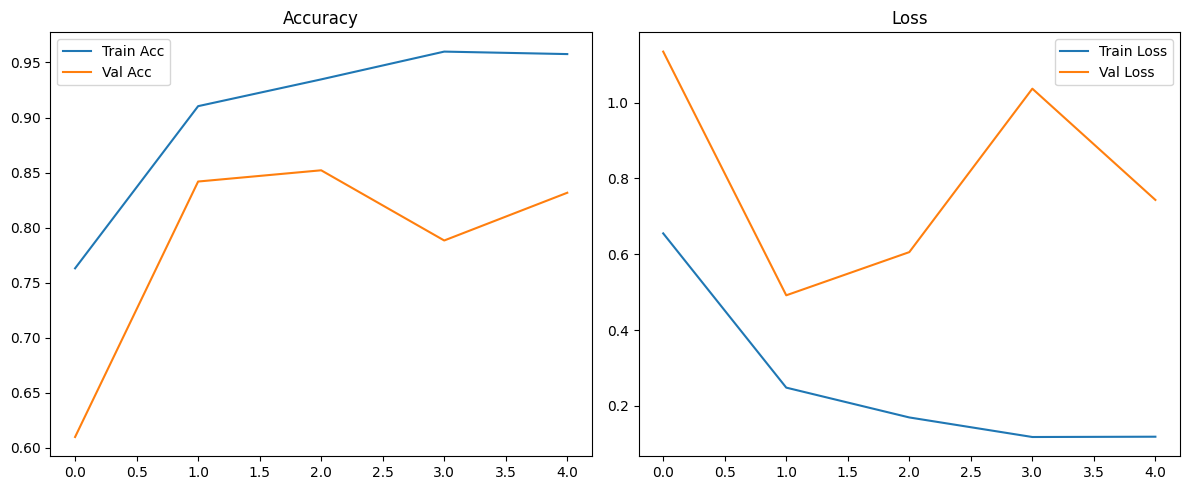

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.8597 - loss: 0.4603
✅ Test Accuracy: 0.8545
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.74      0.96      0.84       185
meningioma_tumor       0.83      0.81      0.82       188
        no_tumor       1.00      0.81      0.90       100
 pituitary_tumor       0.99      0.81      0.89       180

        accuracy                           0.85       653
       macro avg       0.89      0.85      0.86       653
    weighted avg       0.87      0.85      0.86       653



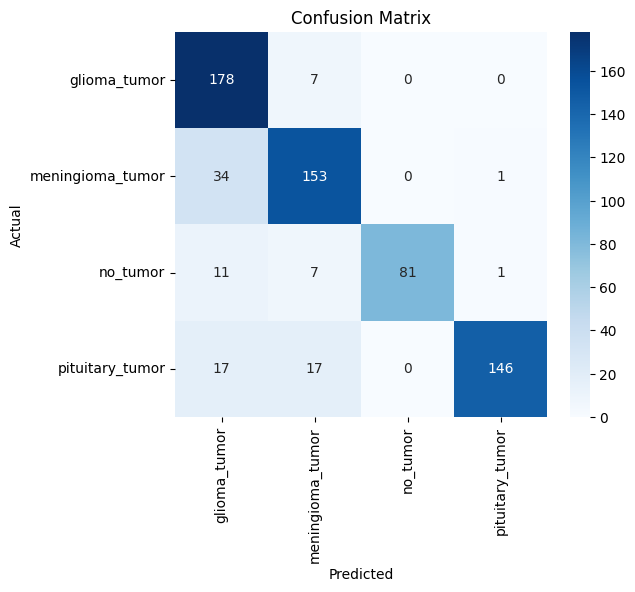

In [15]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ⚙️ Parameters
DATASET_PATH = "/kaggle/input/sartaj-dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5  # Increase for better performance

# 🧠 Step 1: Recursively find images & classes
valid_exts = (".png", ".jpg", ".jpeg")
image_paths = glob.glob(os.path.join(DATASET_PATH, "**", "*.*"), recursive=True)
image_paths = [p for p in image_paths if p.lower().endswith(valid_exts)]

if not image_paths:
    raise ValueError("❌ No images found. Please check dataset path or file types.")

# Class name is assumed to be the folder just above the image file
labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
df = pd.DataFrame({"filename": image_paths, "class": labels})

print(f"✅ Total images found: {len(df)}")
print("🧾 Class distribution:\n", df['class'].value_counts())
print(df.sample(5))  # Show preview

NUM_CLASSES = df['class'].nunique()

# 🧪 Step 2: Split dataset
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)

# 🔄 Step 3: Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                              target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                              class_mode='categorical')
val_gen = valid_datagen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                            class_mode='categorical', shuffle=False)

# 🔧 Step 4: Build model using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

# ⚙️ Step 5: Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 📦 Step 6: Callbacks
checkpoint = ModelCheckpoint('resnet50_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🏋️ Step 7: Train model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=EPOCHS,
                    callbacks=[checkpoint, earlystop])

# 📈 Step 8: Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 🧪 Step 9: Evaluate on test set
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")

# 🧾 Step 10: Classification report and confusion matrix
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [20]:
# 📊 Show final test accuracy and loss
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Final Test Loss: {test_loss:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8597 - loss: 0.4603

✅ Final Test Accuracy: 85.45%
📉 Final Test Loss: 0.4710
